# Exploratory Data Analysys & Feature Engineering (FE) & Feature Reduction

Previously the data was downloaded, combined into one file, and cleaned. 

We can now perform some exploration, engineer features, and reduce the feature space. 

Lets load the data.

In [1]:
import sys; 
sys.path.append("../..")
import pandas as pd

clean_df = pd.read_csv("../generated_data/clean_finance_data.csv", index_col='date')
clean_df

,comodities__DHHNGSP__DHHNGSP,comodities__fredgraph__DCOILBRENTEU,comodities__fredgraph__MHHNGSP,comodities__DCOILWTICO__DCOILWTICO,interest_&_credit__DGS10__DGS10,interest_&_credit__DGS2__DGS2,interest_&_credit__CPN3M__CPN3M,interest_&_credit__DGS1__DGS1,interest_&_credit__DGS5__DGS5,interest_&_credit__DBAA__DBAA,...,SPY_vwap,SPY_transactions,FX_AUDUSD_close,FX_EURUSD_close,FX_GBPUSD_close,FX_NZDUSD_close,FX_USDCAD_close,FX_USDCHF_close,FX_USDJPY_close,FX_USDSEK_close
date,,,,,,,,,,,,,,,,,,,,,
2020-09-03,2.32,40.91,1.92,41.39,0.63,0.13,0.12,0.12,0.24,3.27,...,348.2010,867631.0,0.733111,1.184736,1.335131,0.676750,1.30446,0.91118,106.208000,8.71406
2020-09-04,1.80,40.91,1.92,39.69,0.72,0.14,0.12,0.13,0.30,3.40,...,341.7648,795603.0,0.725584,1.183978,1.326225,0.668910,1.31397,0.91004,106.085999,8.74122
2020-09-05,1.80,40.91,1.92,39.69,0.72,0.14,0.12,0.13,0.30,3.40,...,341.7648,795603.0,0.725584,1.183978,1.326225,0.668910,1.31397,0.91004,106.085999,8.74122
2020-09-06,1.80,40.91,1.92,39.69,0.72,0.14,0.12,0.13,0.30,3.40,...,341.7648,795603.0,0.725584,1.183978,1.326225,0.668910,1.31397,0.91004,106.085999,8.74122
2020-09-07,1.80,40.91,1.92,39.69,0.72,0.14,0.12,0.13,0.30,3.40,...,341.7648,795603.0,0.728221,1.183446,1.324574,0.671290,1.30757,0.91357,106.310997,8.73689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-01,3.96,68.13,3.42,71.61,4.17,3.87,4.32,4.01,3.91,5.90,...,559.1036,603800.0,0.624189,1.081888,1.292090,0.567051,1.43907,0.88382,149.912994,10.03998
2025-04-02,4.04,68.13,3.42,72.12,4.20,3.91,4.32,4.04,3.95,5.93,...,560.9113,686534.0,0.628958,1.079599,1.292307,0.571389,1.42921,0.88340,149.783005,10.01032
2025-04-03,4.21,68.13,3.42,67.43,4.06,3.71,4.32,3.92,3.75,5.95,...,543.2540,1198719.0,0.626470,1.090869,1.304631,0.572761,1.42165,0.87679,147.871994,9.86130


We should verify the data is clean.

In [2]:
clean_df.index = pd.to_datetime(clean_df.index, errors="coerce")
clean_df = clean_df.sort_index()

expected = pd.date_range(start=clean_df.index.min(),
                         end=clean_df.index.max(),
                         freq="D") 

missing = expected.difference(clean_df.index)
print("Number of missing dates:", len(missing))
print("Sample missing:", missing[:10])


Number of missing dates: 0
Sample missing: DatetimeIndex([], dtype='datetime64[ns]', freq='D')


Now we look at the shape.

In [3]:
clean_df.shape

(1676, 71)

The dataset contains 1676 rows, and 71 columns. 

We can also check the organization and range of the data. 

In [4]:
dup_dates = clean_df.index[clean_df.index.duplicated()]
print("Number of duplicate timestamps:", dup_dates.size)

Number of duplicate timestamps: 0


In [5]:
is_sorted = clean_df.index.is_monotonic_increasing
print(is_sorted)

True


In [6]:
idx = pd.to_datetime(clean_df.index, errors="coerce")
dmin, dmax = idx.min(), idx.max()
nrows = idx.notna().sum()

print(f"Date range: {dmin.date()} → {dmax.date()}  | rows: {nrows - 1:,}")

Date range: 2020-09-03 → 2025-04-05  | rows: 1,675


The data ranges from late 2020 to early 2025 and contains 1675 days of information. 

What data types make up this dataset?

In [7]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1676 entries, 2020-09-03 to 2025-04-05
Data columns (total 71 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   comodities__DHHNGSP__DHHNGSP                           1676 non-null   float64
 1   comodities__fredgraph__DCOILBRENTEU                    1676 non-null   float64
 2   comodities__fredgraph__MHHNGSP                         1676 non-null   float64
 3   comodities__DCOILWTICO__DCOILWTICO                     1676 non-null   float64
 4   interest_&_credit__DGS10__DGS10                        1676 non-null   float64
 5   interest_&_credit__DGS2__DGS2                          1676 non-null   float64
 6   interest_&_credit__CPN3M__CPN3M                        1676 non-null   float64
 7   interest_&_credit__DGS1__DGS1                          1676 non-null   float64
 8   interest_&_credit__DGS5__DGS5 

The current features are all numerical. Now that we have varified the basic format of the data lets create some additional features. 

In [8]:
import pandas as pd
import numpy as np

print("Initial shape:", clean_df.shape)

windows = [5, 10, 21]
feature_df = clean_df.copy()
numeric_cols = feature_df.select_dtypes(include=[np.number]).columns

new_feature_dfs = []

for col in numeric_cols:
    for window in windows:
        temp = pd.DataFrame(index=feature_df.index)

        roll = feature_df[col].rolling(window=window, min_periods=window)

        # Rolling statistics
        temp[f'{col}_rollmean_{window}'] = roll.mean()
        temp[f'{col}_rollstd_{window}'] = roll.std()
        temp[f'{col}_rollmin_{window}'] = roll.min()
        temp[f'{col}_rollmax_{window}'] = roll.max()
        temp[f'{col}_rollmedian_{window}'] = roll.median()
        temp[f'{col}_rollrange_{window}'] = roll.max() - roll.min()
        temp[f'{col}_roll_mean_abs_dev_{window}'] = roll.apply(lambda x: np.mean(np.abs(x - np.mean(x))), raw=True)
        temp[f'{col}_roll_skew_{window}'] = roll.skew()
        temp[f'{col}_roll_kurt_{window}'] = roll.kurt()

        # EMA
        temp[f'{col}_ema_{window}'] = feature_df[col].ewm(span=window, adjust=False).mean()

        new_feature_dfs.append(temp)

# Combine all features
feature_df = pd.concat([feature_df] + new_feature_dfs, axis=1)

# Interaction features
interaction_df = pd.DataFrame(index=feature_df.index)
interaction_df['yield_spread_10y_2y'] = feature_df['interest_&_credit__DGS10__DGS10'] - feature_df['interest_&_credit__DGS2__DGS2']
interaction_df['oil_spread_wti_brent'] = feature_df['comodities__DCOILWTICO__DCOILWTICO'] - feature_df['comodities__fredgraph__DCOILBRENTEU']
interaction_df['spy_oil_ratio'] = feature_df['SPY_close'] / feature_df['comodities__DCOILWTICO__DCOILWTICO']
interaction_df['spy_m2_ratio'] = feature_df['SPY_close'] / feature_df['mon_conditions__M2SL__M2SL']
interaction_df['usd_index_vs_eur'] = feature_df['FX_USDCHF_close'] / feature_df['FX_EURUSD_close']

# Combine interaction features
feature_df = pd.concat([feature_df, interaction_df], axis=1)

# Replace inf/-inf with NaN (but no dropping yet)
feature_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Save to `clean_df` for next step
clean_df = feature_df.copy()

print("Feature shape before dropna:", clean_df.shape)


Initial shape: (1676, 71)
Feature shape before dropna: (1676, 2206)


We created around 1900 more features from the inital feature set. 

Lets continue with regime based feature engineering.

In [9]:
import numpy as np
import pandas as pd

print("Initial shape (before labeling):", clean_df.shape)

df = clean_df.copy()
window = 7  # For regime z-score window

# Compute returns and volatility
df["ret"] = np.log(df["SPY_close"]).diff()
df["avg_ret"] = df["ret"].rolling(window).mean()
df["avg_vol"] = df["ret"].rolling(window).std()
df["ret_z"] = (df["avg_ret"] - df["avg_ret"].rolling(window).mean()) / df["avg_ret"].rolling(window).std()
df["vol_z"] = (df["avg_vol"] - df["avg_vol"].rolling(window).mean()) / df["avg_vol"].rolling(window).std()

# Label regimes
def bin_return(row):
    if row["ret_z"] < -0.5:
        return "LowRet"
    elif row["ret_z"] > 0.5:
        return "HighRet"
    else:
        return "MedRet"

def bin_vol(row):
    return "HighVol" if row["vol_z"] > 0 else "LowVol"

df["regime_ret"] = df.apply(bin_return, axis=1)
df["regime_vol"] = df.apply(bin_vol, axis=1)
df["regime"] = df["regime_ret"] + "_" + df["regime_vol"]

# FINAL CLEAN: Now drop all NaNs
df.dropna(inplace=True)

print("Final shape after feature additions, regime, and dropna:", df.shape)

# Final clean dataset
clean_df = df.copy()


Initial shape (before labeling): (1676, 2206)
Final shape after feature additions, regime, and dropna: (1656, 2214)


In [10]:
# Class distribution in the final dataset
print("\nClass distribution of `regime` (counts):")
print(df["regime"].value_counts().sort_index())

print("\nClass distribution of `regime` (proportions):")
print(df["regime"].value_counts(normalize=True).sort_index().round(4))



Class distribution of `regime` (counts):
regime
HighRet_HighVol    306
HighRet_LowVol     295
LowRet_HighVol     352
LowRet_LowVol      331
MedRet_HighVol     198
MedRet_LowVol      174
Name: count, dtype: int64

Class distribution of `regime` (proportions):
regime
HighRet_HighVol    0.1848
HighRet_LowVol     0.1781
LowRet_HighVol     0.2126
LowRet_LowVol      0.1999
MedRet_HighVol     0.1196
MedRet_LowVol      0.1051
Name: proportion, dtype: float64


We will be attempting to predict future regimes. Knowing this, the regime classes appear to be somewhat evenely distributed, although classes 5 and 6 are slightly less common then the rest of the classes. We can visulize regimes to gain more insight. 

In [11]:
# Encode regimes as integers
regime_map = {label: i+1 for i, label in enumerate(sorted(df["regime"].unique()))}
df["regime"] = df["regime"].map(regime_map)

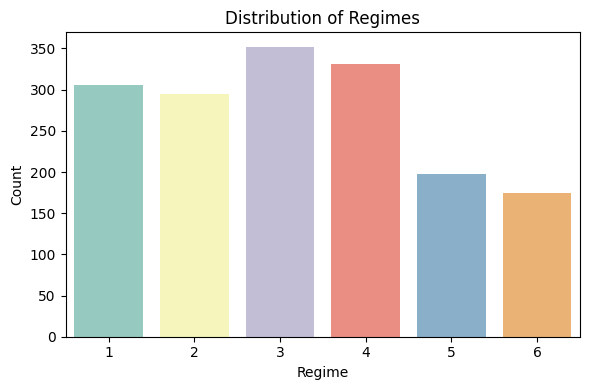

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.countplot(x="regime", data=df, palette="Set3", hue='regime', legend=False)
plt.title("Distribution of Regimes")
plt.xlabel("Regime")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


Now by looking at the regimes over time (below) in the SPY index we can see they appear somewhat naturally distributed (there are no obvious blocks over any specific time period).

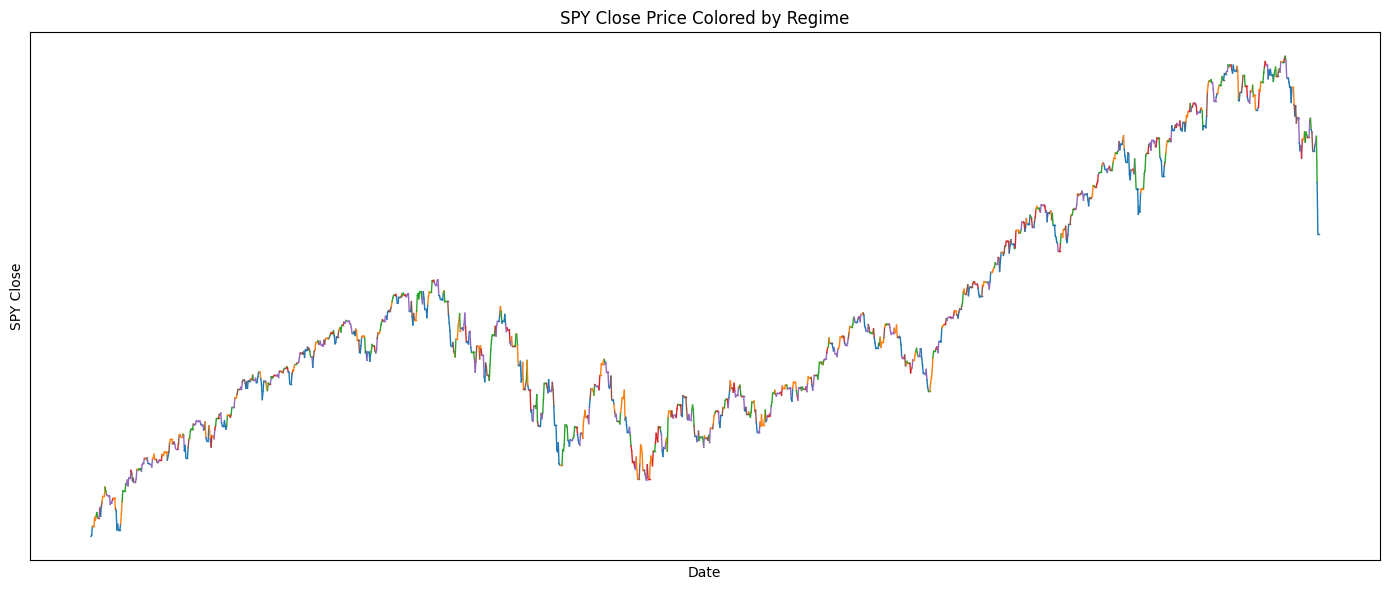

In [13]:
import matplotlib.pyplot as plt
import matplotlib as mpl

regimes = df["regime"].unique()
colors = dict(zip(regimes, plt.cm.tab10.colors[:len(regimes)]))
plt.figure(figsize=(14,6))
for i in range(len(df)-1):
    regime = df["regime"].iloc[i]
    plt.plot(
        df.index[i:i+2], 
        df["SPY_close"].iloc[i:i+2],
        color=colors[regime],
        lw=1
    )

plt.title("SPY Close Price Colored by Regime")
plt.xlabel("Date")
plt.ylabel("SPY Close")
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

We should also take a look at some distribution plots and timeseries plots for a sample of the features we have in this dataset.

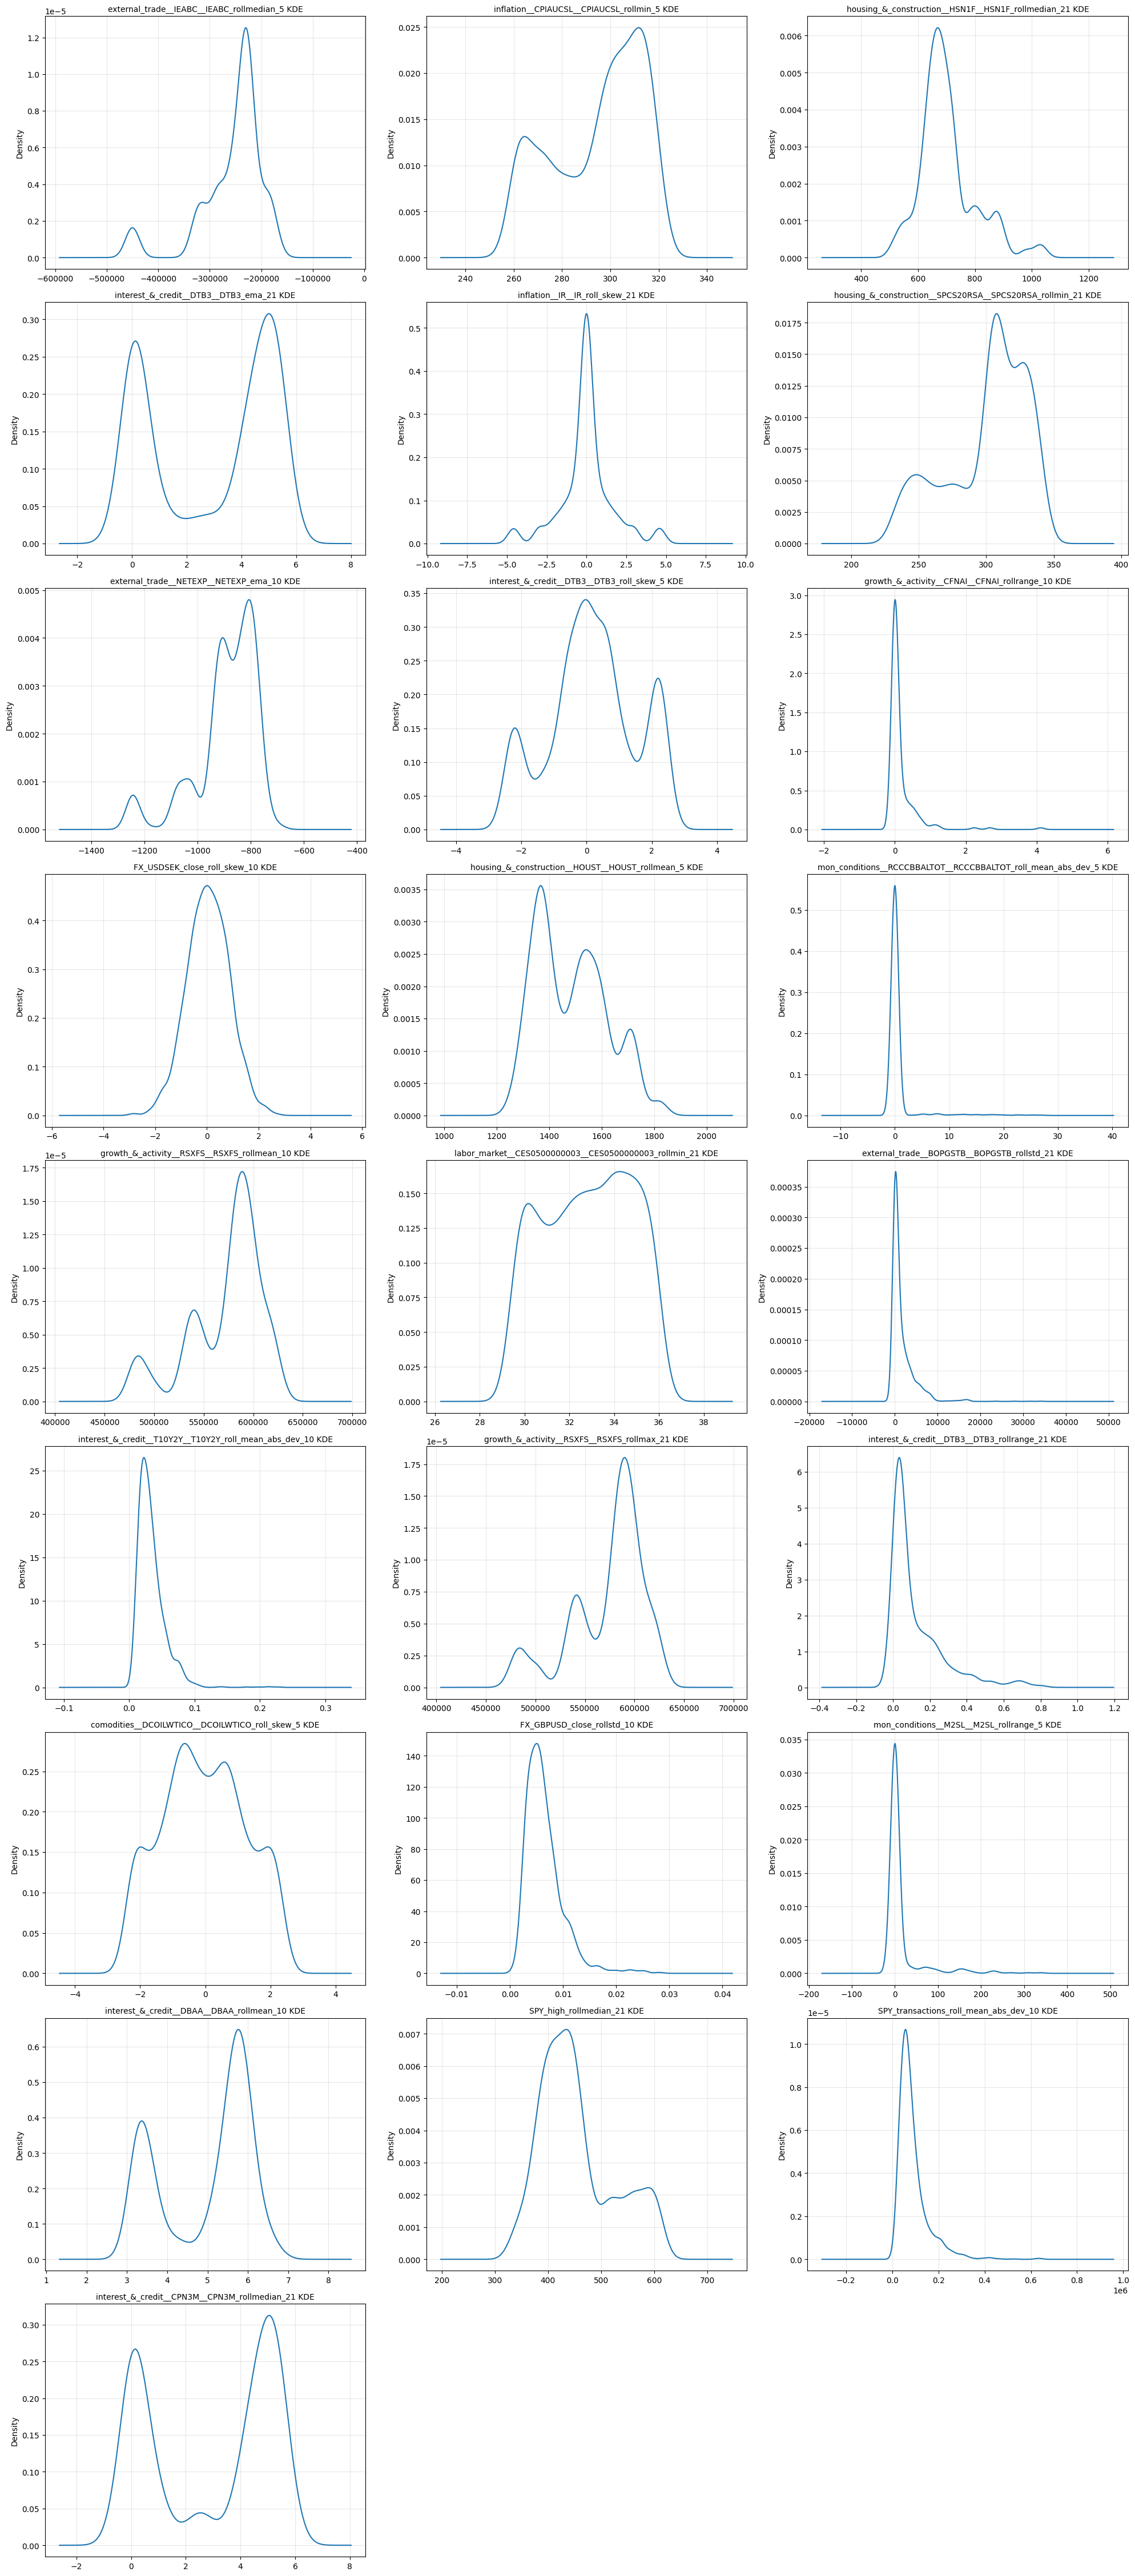

In [14]:
import matplotlib.pyplot as plt
import numpy as np

n_cols_to_plot = 25
numeric_cols = df.select_dtypes(include=np.number).columns

np.random.seed(42)
sampled_cols = np.random.choice(numeric_cols, size=min(n_cols_to_plot, len(numeric_cols)), replace=False)

fig, axes = plt.subplots(nrows=10, ncols=3, figsize=(20, 50)) 
axes = axes.flatten()
for i, col in enumerate(sampled_cols):
    df[col].dropna().plot.kde(ax=axes[i])
    axes[i].set_title(f"{col} KDE", fontsize=10)
    axes[i].grid(True, alpha=0.3)

for j in range(len(sampled_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


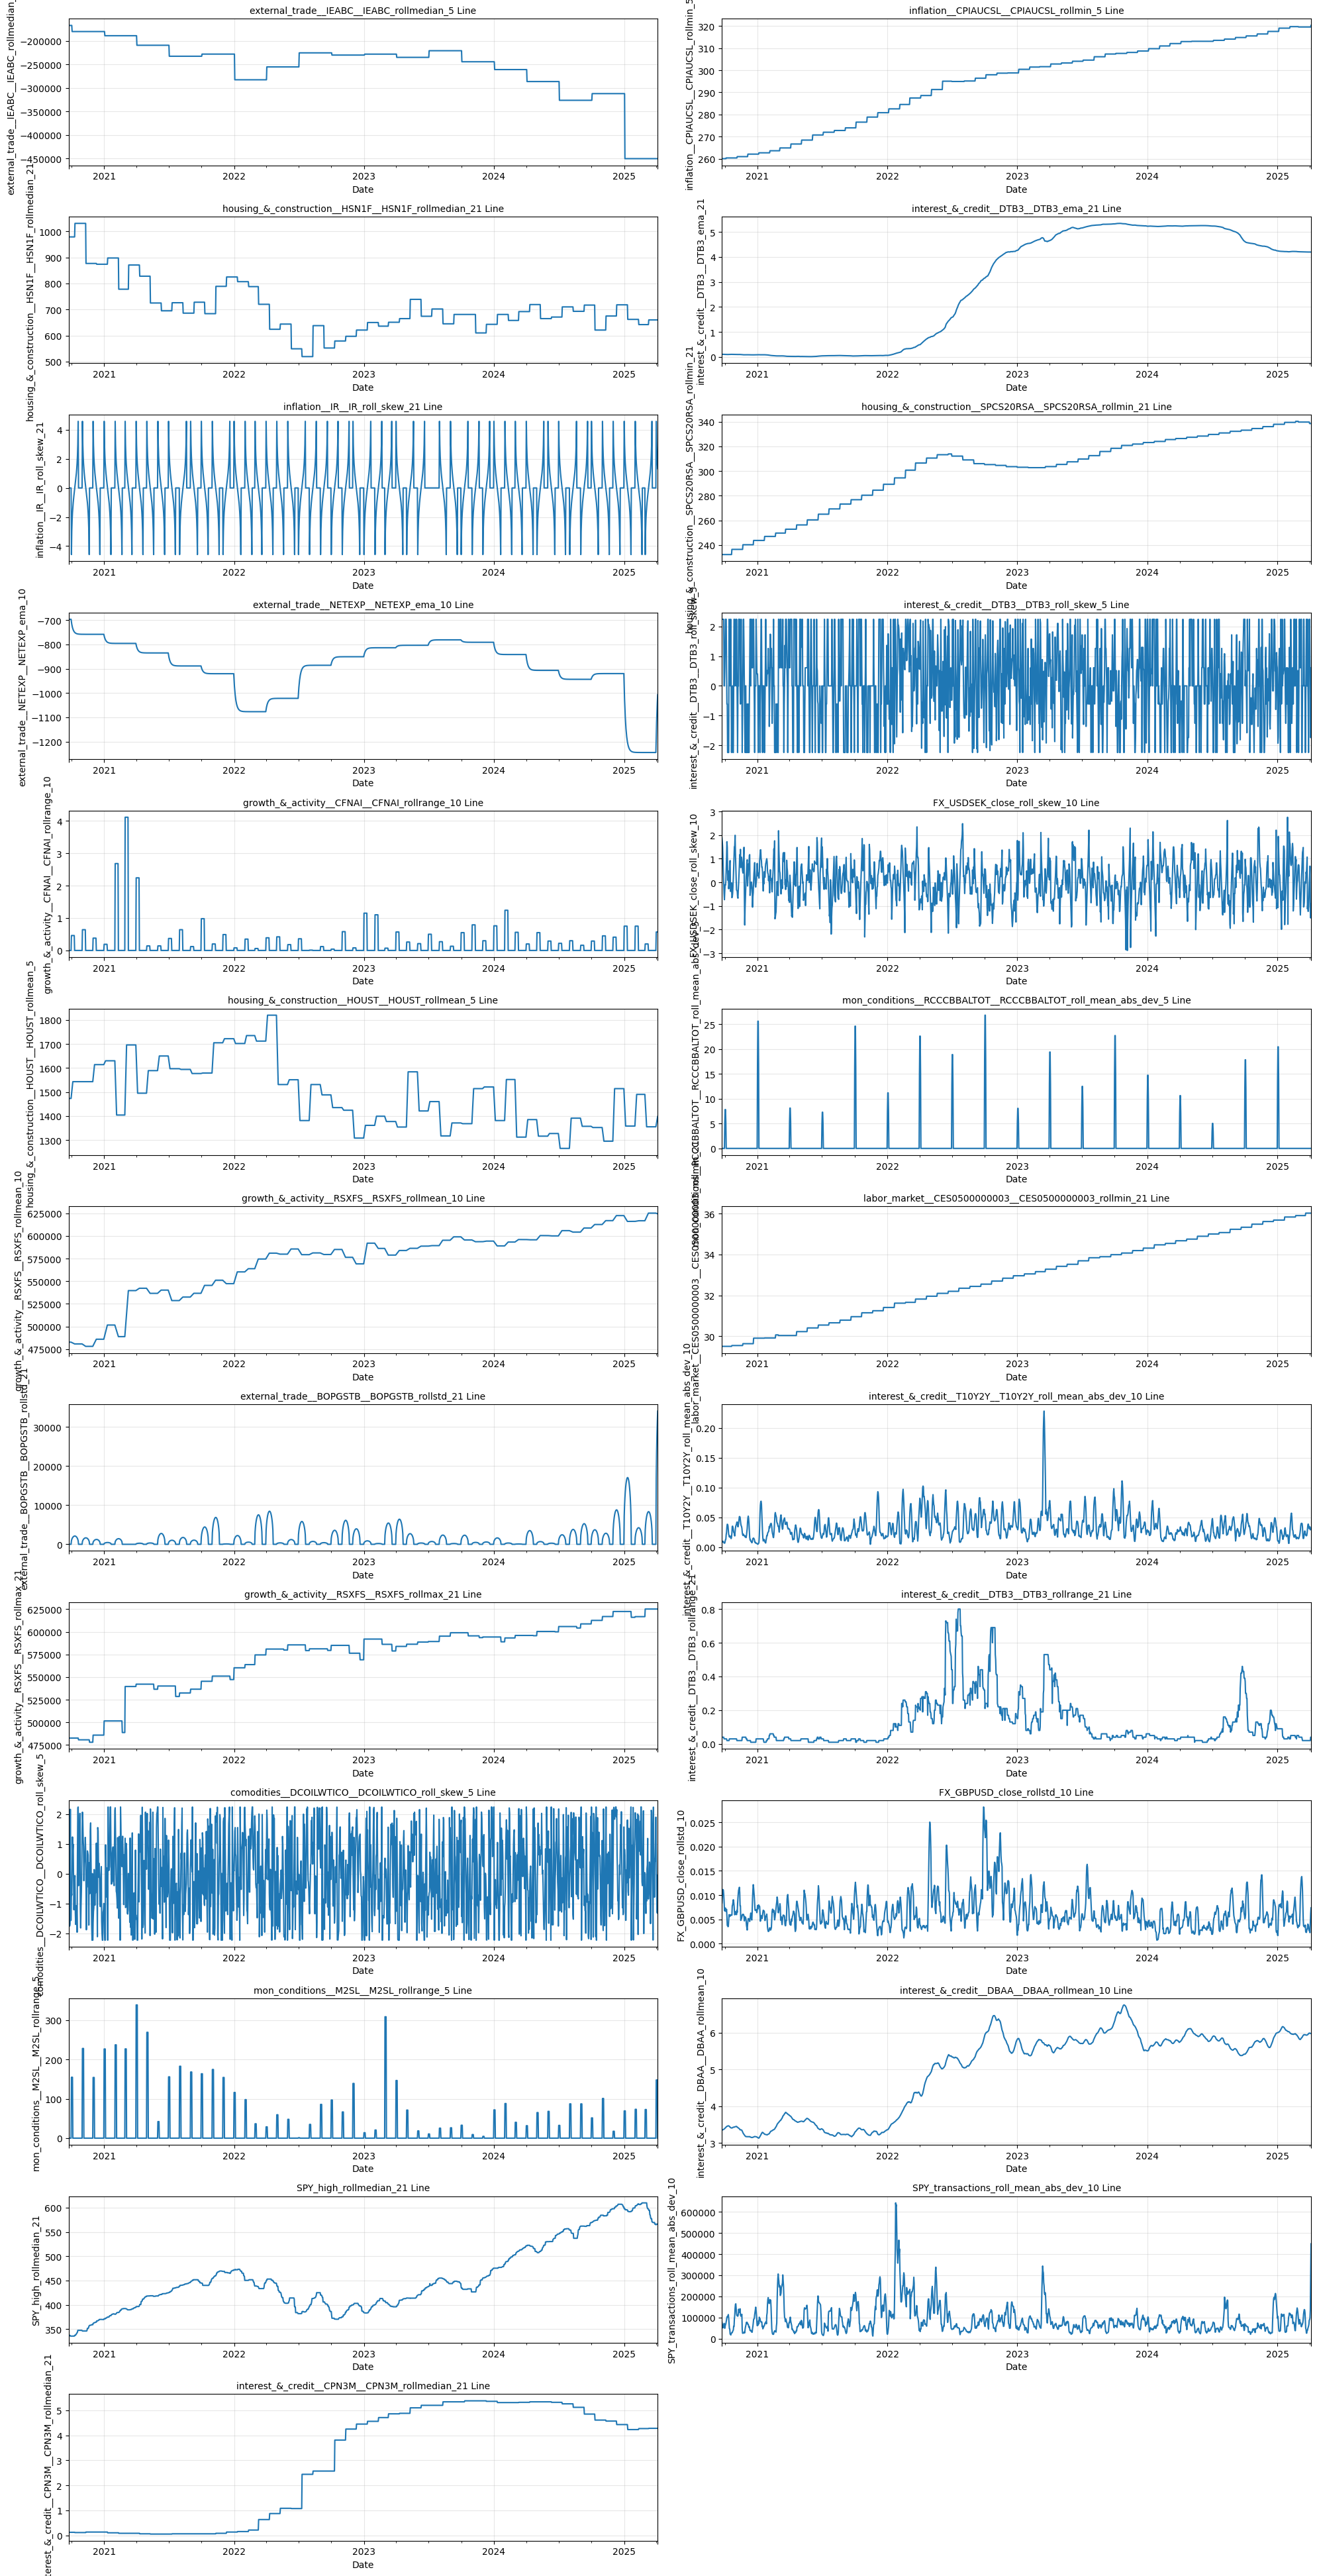

In [15]:
import matplotlib.pyplot as plt
import numpy as np

n_cols_to_plot = 25 
numeric_cols = df.select_dtypes(include="number").columns

np.random.seed(42)
sampled_cols = np.random.choice(numeric_cols, size=min(n_cols_to_plot, len(numeric_cols)), replace=False)

rows = int(np.ceil(len(sampled_cols) / 2))
fig, axes = plt.subplots(nrows=rows, ncols=2, figsize=(20, rows * 3))
axes = axes.flatten()

for i, col in enumerate(sampled_cols):
    df[col].dropna().plot(ax=axes[i])
    axes[i].set_title(f"{col} Line", fontsize=10)
    axes[i].set_xlabel("Date")
    axes[i].set_ylabel(col)
    axes[i].grid(True, alpha=0.3)

for j in range(len(sampled_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


We can see a range of shapes and distributions for the plots above, some features are displaying a trend and some appearing to be stationary.
 
 Since we are working with time series data we will convert all non-stationary features to stationary. 

In [16]:
import numpy as np
import pandas as pd
from utils.stationarity_tests import test_stationarity

regime = df.pop("regime")

stationarity_results = {}
processed_cols = {}

for col in df.select_dtypes(include=np.number).columns:
    series = df[col].dropna()
    diff_count = 0

    while diff_count < 3:
        try:
            result = test_stationarity(series, name=col)
        except ValueError:
            break
        if result[col]["stationary"]:
            stationarity_results[col] = {"stationary": True, "diffs_applied": diff_count}
            break
        else:
            series = series.diff().dropna()
            diff_count += 1
    else:
        stationarity_results[col] = {"stationary": False, "diffs_applied": diff_count}

    if series.std() != 0:
        series = (series - series.mean()) / series.std()

    processed_cols[col] = series.reindex(df.index)
    
df_stationary = pd.concat(processed_cols.values(), axis=1)
df_stationary.columns = list(processed_cols.keys())

df_stationary["regime"] = regime
df_stationary = df_stationary.dropna()

print(f"\nTransformed stationary + normalized dataset with {df_stationary.shape[0]} rows and {df_stationary.shape[1]} columns ")



Transformed stationary + normalized dataset with 1654 rows and 2212 columns 


Lets save the data into train and test sets and reload it. 

In [17]:
import pandas as pd

split_idx = int(len(df_stationary) * 0.7)
train_df = df_stationary.iloc[:split_idx]
test_df = df_stationary.iloc[split_idx:]

In [18]:
train_df.shape

(1157, 2212)

The train set has 2212 inital features and 1156 days of information. 

In [19]:
test_df.shape

(497, 2212)

The test set has 2212 inital features and 496 days of information. 

Save and reload

In [20]:
train_df.to_csv("../../data/generated_data/train.csv")
test_df.to_csv("../../data/generated_data/test.csv")
train_df = pd.read_csv("../../data/generated_data/train.csv", index_col=0)
test_df = pd.read_csv("../../data/generated_data/test.csv", index_col=0)

Now that we have loaded the robust feature data we can start feature reduction. For the feature reduction steps we will use strictly training data, but update both the train and test sets as we go. 

Lets start reducing the feature dimensionality space based on a random forrest classifier and a random noise feature-importance-threshold.  

In [21]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier

train = train_df.copy()

train['shifted_regime'] = train['regime'].shift(-1)
train = train.dropna(subset=['shifted_regime'])

train_y = train['shifted_regime'].astype(int)

train_features = train.drop(columns=['shifted_regime']) 

train_X = train_features.select_dtypes(include=np.number).copy()

np.random.seed(42)
train_X['__random_noise__'] = np.random.randn(len(train_X))

rf = RandomForestClassifier(n_estimators=1000, random_state=42, n_jobs=-1)
rf.fit(train_X, train_y)

feature_importance = pd.Series(rf.feature_importances_, index=train_X.columns)

noise_threshold = feature_importance["__random_noise__"]
selected_features = feature_importance[feature_importance > noise_threshold].index

selected_features = selected_features.drop('__random_noise__', errors='ignore')

reduced_train_df = train_df[selected_features.to_list()].copy()

if 'regime' not in reduced_train_df.columns:
    reduced_train_df['regime'] = train_df['regime']

existing_features = [f for f in selected_features if f in test_df.columns]
reduced_test_df = test_df[existing_features].copy()

if 'regime' not in reduced_test_df.columns and 'regime' in test_df.columns:
    reduced_test_df['regime'] = test_df['regime']


print("Original train shape:", train_df.shape)
print("Filtered train shape:", reduced_train_df.shape)
print("Filtered test shape:", reduced_test_df.shape)
print(f"Kept {len(selected_features)} features better than random noise")
print("Top features:\n", selected_features.to_list())


Original train shape: (1157, 2212)
Filtered train shape: (1157, 575)
Filtered test shape: (497, 575)
Kept 575 features better than random noise
Top features:
 ['market_sentiment__VIXCLS__VIXCLS', 'SPY_high', 'SPY_low', 'SPY_close', 'SPY_vwap', 'SPY_transactions', 'comodities__DHHNGSP__DHHNGSP_rollmean_5', 'comodities__DHHNGSP__DHHNGSP_rollstd_5', 'comodities__DHHNGSP__DHHNGSP_roll_skew_5', 'comodities__DHHNGSP__DHHNGSP_roll_kurt_5', 'comodities__DHHNGSP__DHHNGSP_ema_5', 'comodities__DHHNGSP__DHHNGSP_rollmean_10', 'comodities__DHHNGSP__DHHNGSP_rollstd_10', 'comodities__DHHNGSP__DHHNGSP_roll_mean_abs_dev_10', 'comodities__DHHNGSP__DHHNGSP_roll_skew_10', 'comodities__DHHNGSP__DHHNGSP_ema_10', 'comodities__DHHNGSP__DHHNGSP_rollmean_21', 'comodities__DHHNGSP__DHHNGSP_rollstd_21', 'comodities__DHHNGSP__DHHNGSP_roll_mean_abs_dev_21', 'comodities__DHHNGSP__DHHNGSP_roll_skew_21', 'comodities__DHHNGSP__DHHNGSP_roll_kurt_21', 'comodities__DHHNGSP__DHHNGSP_ema_21', 'comodities__fredgraph__DCOILBRE

Using a random forrest classifier we reduced the feature space from 2212 to 575

Lets visualize the cutoff. 

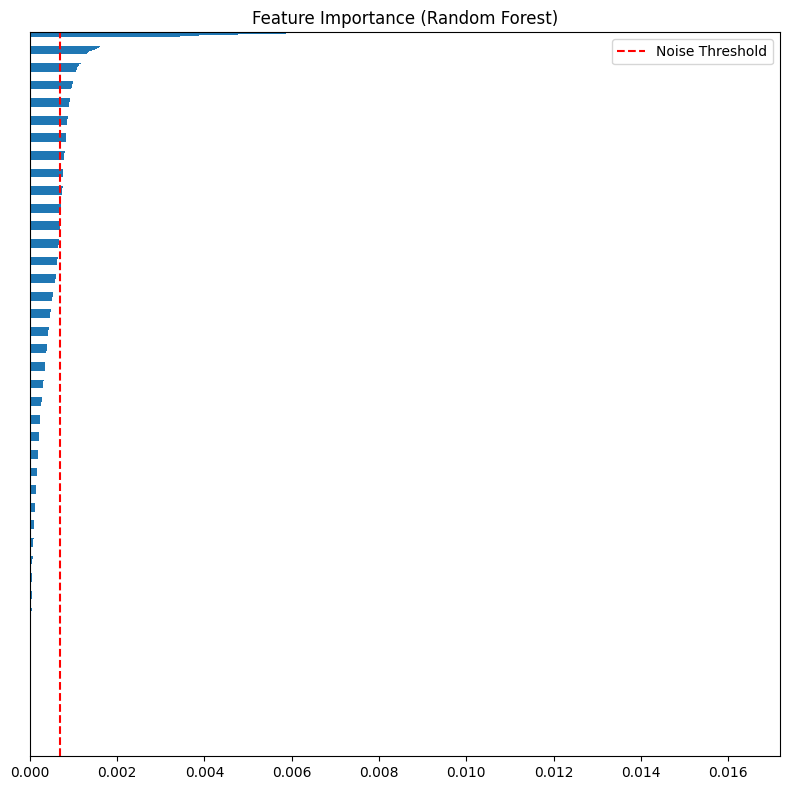

In [22]:
import matplotlib.pyplot as plt

feature_importance.sort_values().plot(kind="barh", figsize=(8, 8))
plt.axvline(x=noise_threshold, color="red", linestyle="--", label="Noise Threshold")
plt.title("Feature Importance (Random Forest)")
plt.legend()
plt.yticks([])
plt.tight_layout()
plt.show()

Save and reload. 

In [23]:
reduced_train_df.to_csv("../../data/generated_data/train.csv", index=False)
reduced_test_df.to_csv("../../data/generated_data/test.csv", index=False)
train_df = pd.read_csv("../../data/generated_data/train.csv", index_col=0)
test_df = pd.read_csv("../../data/generated_data/test.csv", index_col=0)

We can also reduce the feature space based on variance.

In [24]:
from sklearn.feature_selection import VarianceThreshold
import numpy as np
import pandas as pd

print("Original train shape:", train_df.shape)

# Separate regime column (preserve for later)
regime_train = train_df['regime']
regime_test = test_df['regime'] if 'regime' in test_df.columns else None

# Drop regime and get numeric features
X_train = train_df.select_dtypes(np.number).drop(columns=['regime'], errors='ignore')

# Fit variance threshold on train
selector = VarianceThreshold(threshold=1)
X_train_reduced = selector.fit_transform(X_train)

# Get retained features
kept_features = X_train.columns[selector.get_support()]
print("Kept features:", kept_features)

# Transform test using same features
X_test_reduced = test_df.select_dtypes(np.number)[kept_features]

# Rebuild reduced dataframes
reduced_train_df = pd.DataFrame(X_train_reduced, columns=kept_features, index=train_df.index)
reduced_train_df['regime'] = regime_train

reduced_test_df = pd.DataFrame(X_test_reduced, columns=kept_features, index=test_df.index)
if regime_test is not None:
    reduced_test_df['regime'] = regime_test

print("Reduced train shape:", reduced_train_df.shape)

Original train shape: (1157, 574)
Kept features: Index(['SPY_transactions', 'comodities__DHHNGSP__DHHNGSP_roll_skew_5',
       'comodities__DHHNGSP__DHHNGSP_roll_skew_10',
       'comodities__fredgraph__DCOILBRENTEU_ema_21',
       'comodities__fredgraph__MHHNGSP_ema_5',
       'comodities__fredgraph__MHHNGSP_ema_10',
       'comodities__fredgraph__MHHNGSP_ema_21',
       'comodities__DCOILWTICO__DCOILWTICO_rollmean_5',
       'comodities__DCOILWTICO__DCOILWTICO_roll_mean_abs_dev_5',
       'comodities__DCOILWTICO__DCOILWTICO_ema_5',
       ...
       'FX_USDSEK_close_roll_mean_abs_dev_5', 'FX_USDSEK_close_rollmean_10',
       'FX_USDSEK_close_rollmedian_10', 'FX_USDSEK_close_ema_10',
       'FX_USDSEK_close_rollstd_21', 'FX_USDSEK_close_roll_skew_21', 'ret',
       'avg_ret', 'avg_vol', 'ret_z'],
      dtype='object', length=317)
Reduced train shape: (1157, 318)


Using a variance threshold we reduced the feature space from 575 to 318.

Save and reload

In [25]:
reduced_train_df.to_csv("../../data/generated_data/train.csv", index=False)
reduced_test_df.to_csv("../../data/generated_data/test.csv", index=False)

train_df = pd.read_csv("../../data/generated_data/train.csv", index_col=0)
test_df = pd.read_csv("../../data/generated_data/test.csv", index_col=0)

We can also plot a correlation matrix to visulize remaining feature correlations and additionally remove highly correlated/redundant features.

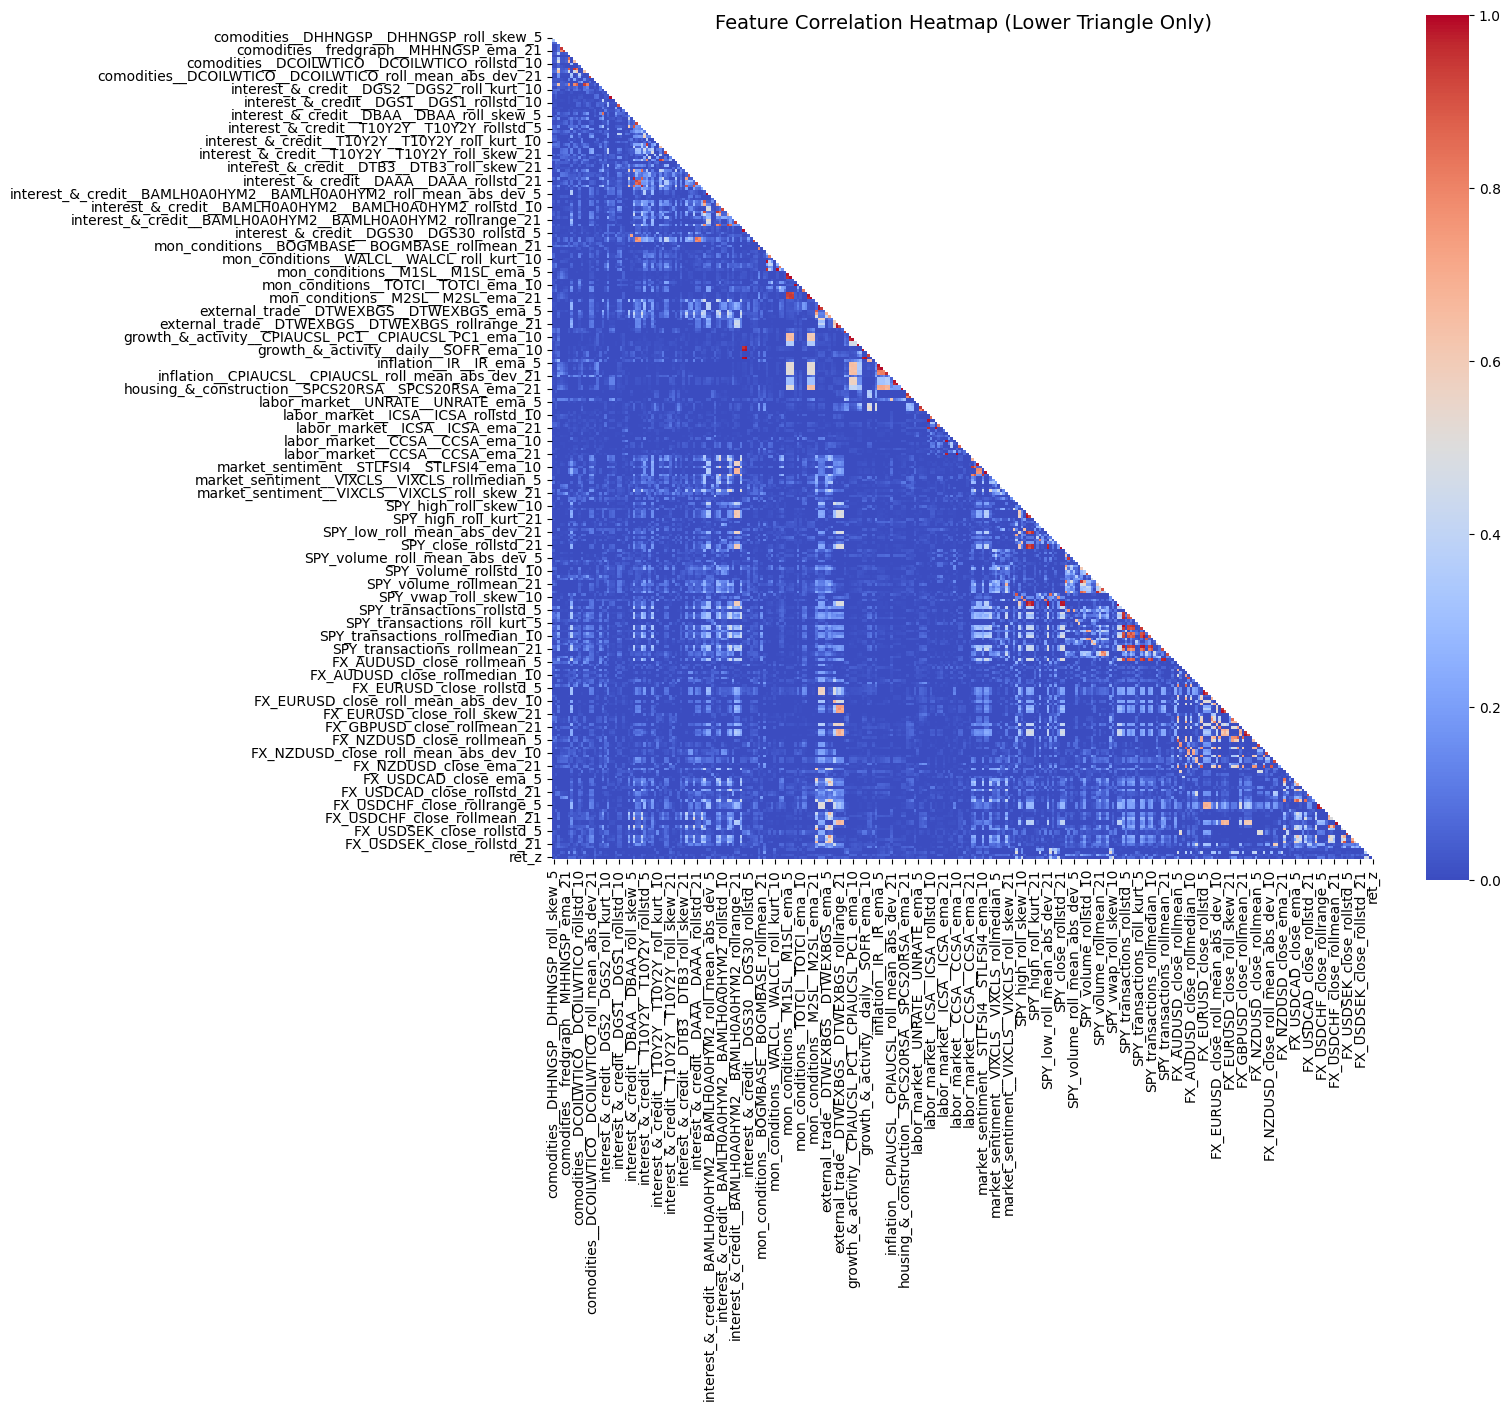

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

regime = train_df.pop("regime")

df = train_df.select_dtypes(np.number)
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(16, 14))
sns.heatmap(
    corr,
    mask=mask,
    cmap="coolwarm",
    vmin=0,
    vmax=1,
    square=True,
)

plt.title("Feature Correlation Heatmap (Lower Triangle Only)", fontsize=14)
plt.tight_layout()
plt.show()


In [27]:
import numpy as np
import pandas as pd


print("Original shape:", train_df.shape)

upper = corr.where(mask)

to_drop = set()
for col in upper.columns:
    for row in upper.index:
        val = upper.loc[row, col]
        if pd.notna(val) and val > 0.90:
            if "SPY" not in row and "SPY" not in col:
                to_drop.add(col)

print(f"Features to drop ({len(to_drop)}):", to_drop)

train_df["regime"] = regime

# reduced dataframe
reduced_train_df = train_df.drop(columns=to_drop)
reduced_test_df = test_df.drop(columns=to_drop)

print("Reduced shape:", reduced_train_df.shape)


Original shape: (1157, 316)
Features to drop (252): {'market_sentiment__STLFSI4__STLFSI4_ema_10', 'mon_conditions__WALCL__WALCL_ema_10', 'FX_USDSEK_close_rollstd_21', 'mon_conditions__WALCL__WALCL_roll_mean_abs_dev_21', 'interest_&_credit__DGS2__DGS2_rollstd_21', 'interest_&_credit__BAMLH0A0HYM2__BAMLH0A0HYM2_ema_5', 'inflation__IR__IR_ema_5', 'interest_&_credit__DAAA__DAAA_roll_mean_abs_dev_21', 'comodities__fredgraph__DCOILBRENTEU_ema_21', 'FX_USDCAD_close_rollmedian_10', 'inflation__PPIACO__PPIACO_ema_5', 'FX_GBPUSD_close_rollrange_10', 'labor_market__CCSA__CCSA_rollstd_21', 'FX_GBPUSD_close_rollmean_5', 'comodities__DCOILWTICO__DCOILWTICO_ema_5', 'mon_conditions__M1SL__M1SL_ema_10', 'market_sentiment__VIXCLS__VIXCLS_rollmedian_10', 'interest_&_credit__OBFR__OBFR_ema_21', 'interest_&_credit__T10Y2Y__T10Y2Y_roll_kurt_21', 'avg_vol', 'comodities__DCOILWTICO__DCOILWTICO_roll_kurt_21', 'FX_EURUSD_close_rollstd_5', 'labor_market__AWHAETP__AWHAETP_ema_21', 'FX_AUDUSD_close_ema_21', 'FX_US

Using correlation we reduced the number of features by correlation from 318 to 65.

Again, lets save the changes and reload the test and train data. 

In [28]:
reduced_train_df.to_csv("../../data/generated_data/train.csv", index=False)
reduced_test_df.to_csv("../../data/generated_data/test.csv", index=False)
train_df = pd.read_csv("../../data/generated_data/train.csv", index_col=0)
test_df = pd.read_csv("../../data/generated_data/test.csv", index_col=0)

Finally, while correlation captures linear relationships, we want to identify features that contain non-linear signal.

We can measure this with mutual informamation (MI) and drop features with low scores.

In [29]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd
import numpy as np

train_df = train_df.select_dtypes(np.number)

X = train_df.drop('regime', axis=1)
y = train_df['regime'].shift(-1)

y = pd.factorize(y)[0]

mi_scores = mutual_info_classif(X, y, discrete_features='auto', random_state=42)

mi_df = pd.DataFrame({
    'Feature': X.columns,
    'MI Score': mi_scores
}).sort_values(by='MI Score', ascending=False)

mi_df


,Feature,MI Score
45,SPY_transactions_rollmax_5,0.363998
44,SPY_transactions_rollmin_5,0.340883
6,SPY_high_rollrange_21,0.321754
53,SPY_transactions_rollmedian_10,0.292162
52,SPY_transactions_rollmax_10,0.269624
...,...,...
47,SPY_transactions_roll_skew_5,0.000000
9,SPY_low_roll_skew_5,0.000000
4,SPY_high_roll_kurt_10,0.000000
39,SPY_vwap_roll_kurt_10,0.000000


Lets visualize feature Mutual Information

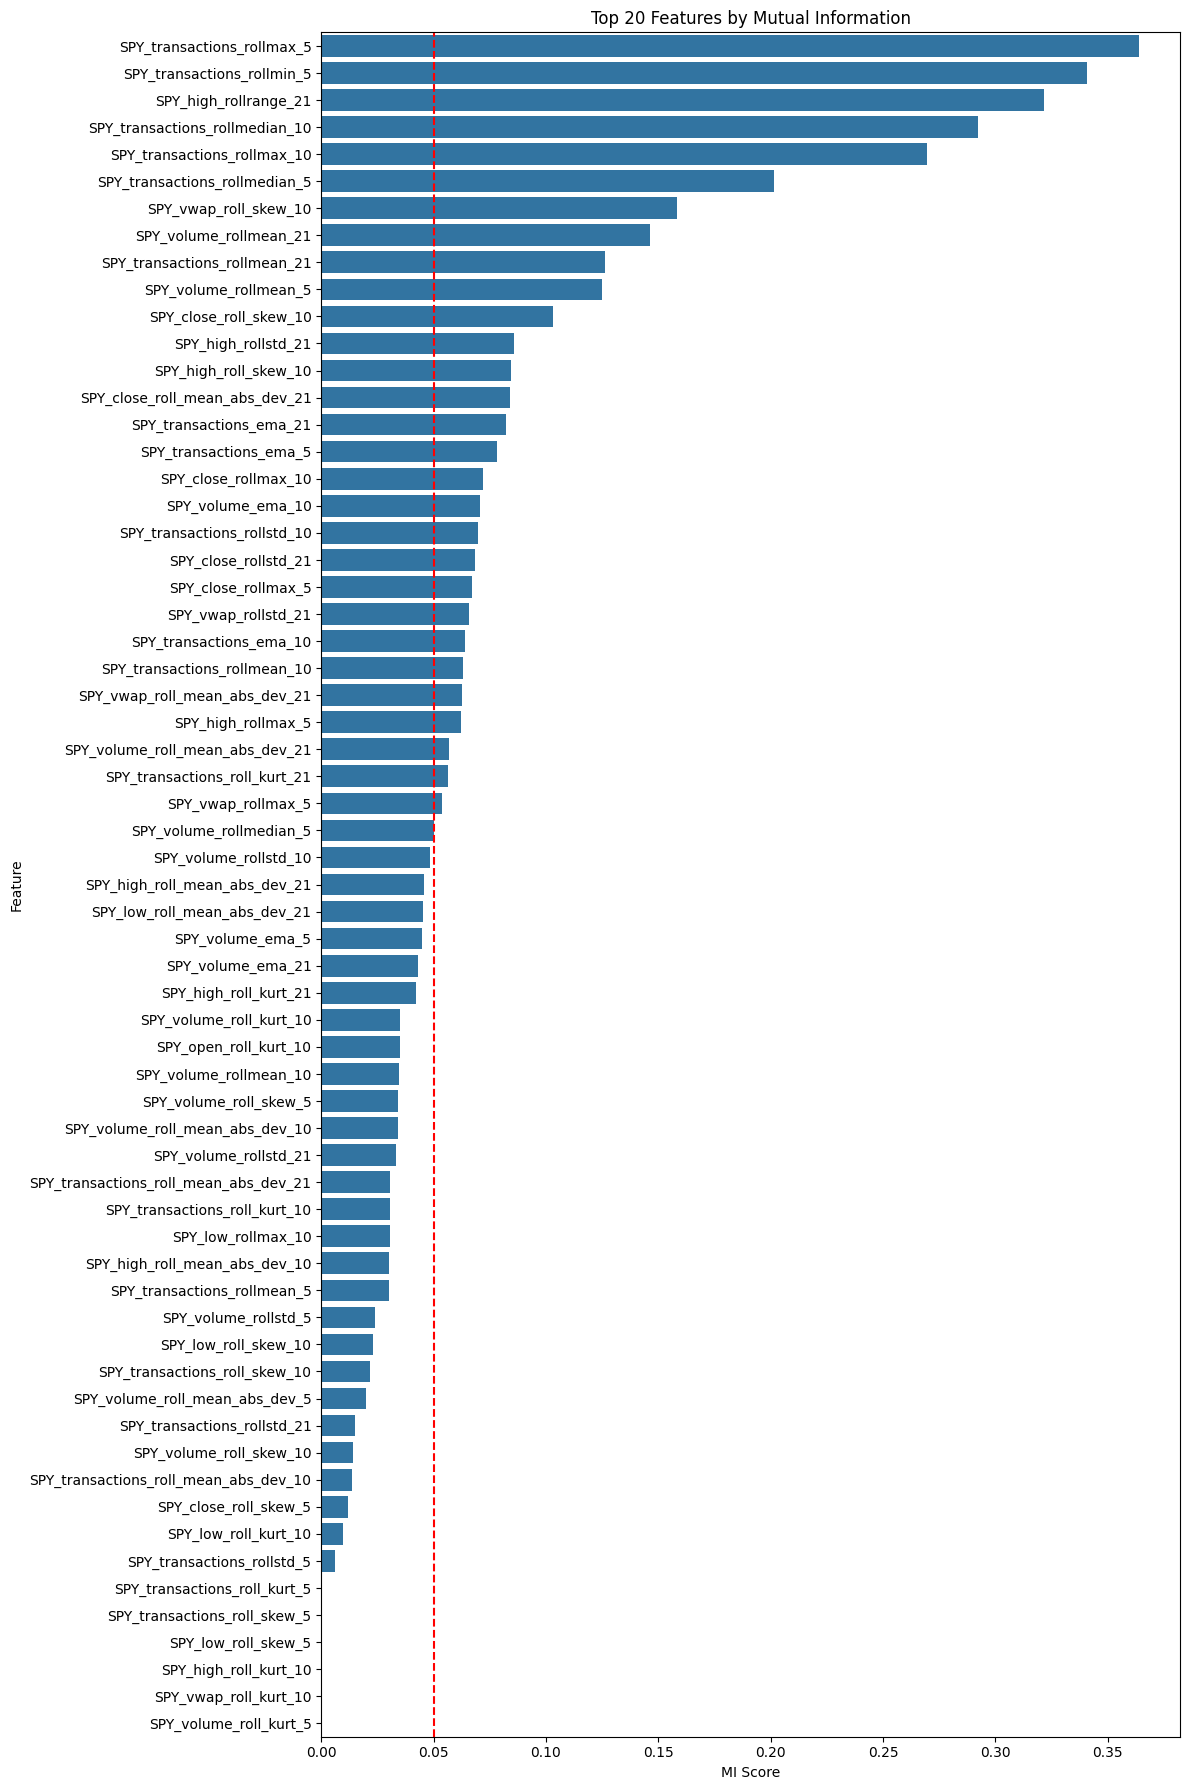

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 18))
sns.barplot(x='MI Score', y='Feature', data=mi_df)
plt.axvline(x=0.05, color="red", linestyle="--", label="Noise Threshold")
plt.title("Top 20 Features by Mutual Information")
plt.tight_layout()
plt.show()


Drop features with less than 0.05 Mutual Information score.

In [31]:
# Keep only features with MI ≥ 0.05
selected_features = mi_df[mi_df['MI Score'] > 0.05]['Feature'].to_list()

train_filtered = train_df[selected_features + ['regime']].copy()
test_filtered = test_df[selected_features + ['regime']].copy()

print(f"Original features: {X.shape[1]}")
print(f"Features kept (MI ≥ 0.05): {len(selected_features)}")
print("Top kept features:", selected_features[:10])


Original features: 63
Features kept (MI ≥ 0.05): 30
Top kept features: ['SPY_transactions_rollmax_5', 'SPY_transactions_rollmin_5', 'SPY_high_rollrange_21', 'SPY_transactions_rollmedian_10', 'SPY_transactions_rollmax_10', 'SPY_transactions_rollmedian_5', 'SPY_vwap_roll_skew_10', 'SPY_volume_rollmean_21', 'SPY_transactions_rollmean_21', 'SPY_volume_rollmean_5']


Using mutual information we reduced the features from 63 to 30. 

#### SAVE THE DATA 
Lets save the final train and test datasets. 

In [32]:
train_filtered.to_csv("../../data/generated_data/train.csv", index=False)
test_filtered.to_csv("../../data/generated_data/test.csv", index=False)